In [326]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt

In [386]:
users = pd.read_csv('BX-Users.csv', sep = ';', encoding='cp1252')
books = pd.read_csv('BX-Books.csv', sep=';', encoding='cp1252', on_bad_lines='skip', low_memory=False)
book_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='cp1252')

In [387]:
users.columns = users.columns.str.strip().str.lower().str.replace('-', '_')
book_ratings.columns = book_ratings.columns.str.strip().str.lower().str.replace('-', '_')
books.columns = books.columns.str.strip().str.lower().str.replace('-', '_')
books = books.drop(['image_url_m', 'image_url_s', 'image_url_l'], axis = 1)

In [354]:
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [355]:
book_ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [356]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


# User dataset preprocessing

In [388]:
print(sorted(users.age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

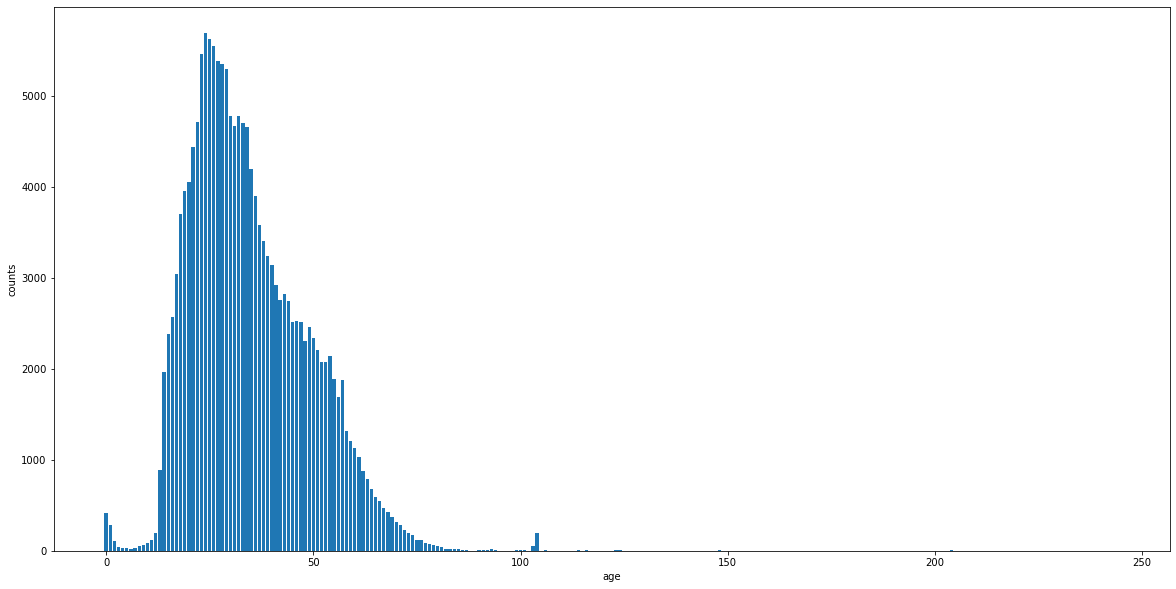

In [389]:
all_users = users.user_id.count()
age_distr = users.age.value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.bar(age_distr.index, age_distr.values)
plt.xlabel('age')
plt.ylabel('counts')
plt.show()

In [390]:
users_fake_age = users[ (users['age'] < 10) | (users['age'] > 110)].user_id.count()
users_fake_age_share = (users_fake_age / all_users) * 100
print(f'{users_fake_age_share:.2f}% of users provided unrealistic age')

0.42% of users provided unrealistic age


As we can see, the number of people of age < 10 and > 110 is very low, so we can dismiss them

In [391]:
age_nan = users.age.isnull().sum()
print(f'There are {age_nan} empty age values in our set of {all_users} users (or {(age_nan/all_users)*100:.2f}%)')

There are 110762 empty age values in our set of 278858 users (or 39.72%)


As the number of people with no age is quite big, we should analyze this subset more carefully 

In [392]:
users_with_age = users.dropna(subset = ['age'])
users_real_age = users_with_age[ (users_with_age['age'] > 10) & (users_with_age['age'] < 110)]

only_rated = book_ratings[book_ratings.book_rating != 0]
number_ratings = only_rated.book_rating.count()

users_ratings = pd.merge(only_rated, users_real_age, how='inner', on = 'user_id')
groupby_ratings = users_ratings.groupby('user_id').isbn.count().sort_values(ascending=False)
groupby_ratings = pd.DataFrame(groupby_ratings)
groupby_ratings.rename(columns = {'isbn':'number_ratings'}, inplace = True)
users_enough_ratings = groupby_ratings[groupby_ratings['number_ratings'] > 20].reset_index()
users_enough_ratings.info()
# users_enough_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2707 entries, 0 to 2706
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         2707 non-null   int64
 1   number_ratings  2707 non-null   int64
dtypes: int64(2)
memory usage: 42.4 KB


Only 2707 users rated more than 20 books

# Books dataset preprocessing

In [393]:
books.loc[books['isbn'] == '078946697X', 'year_of_publication'] = 2000
books.loc[books['isbn'] == '078946697X', 'book_author'] = 'Michael Teitelbaum'
books.loc[books['isbn'] == '078946697X', 'publisher'] = 'DK Publishing Inc'
books.loc[books['isbn'] == '078946697X', 'book_title'] = 'K Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

books.loc[books['isbn'] == '0789466953', 'year_of_publication'] = 2000
books.loc[books['isbn'] == '0789466953', 'book_author'] = 'James Buckley'
books.loc[books['isbn'] == '0789466953', 'publisher'] = 'DK Publishing Inc'
books.loc[books['isbn'] == '0789466953', 'book_title'] = 'K Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'

books.loc[books['isbn'] == '2070426769', 'year_of_publication'] = 2003
books.loc[books['isbn'] == '2070426769', 'book_author'] = 'jean-marie gustave le clézio'
books.loc[books['isbn'] == '2070426769', 'publisher'] = 'Gallimard'
books.loc[books['isbn'] == '2070426769', 'book_title'] = 'Peuple du ciel, suivi de "Les Bergers"'

In [394]:
books_rated_grouped = only_rated.groupby('isbn').agg(mean_rating = ('book_rating', 'mean'), number_of_ratings = ('book_rating', 'count')).reset_index()
books_rated_GT = books_rated_grouped[books_rated_grouped['number_of_ratings']> 50]
books_rated_GT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511 entries, 1926 to 148538
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               511 non-null    object 
 1   mean_rating        511 non-null    float64
 2   number_of_ratings  511 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 16.0+ KB


There are only 511 books in the set with number of ratings > 50

In [423]:
books_rated_GT.sort_values(by='number_of_ratings', ascending=False).head()

,isbn,mean_rating,number_of_ratings
26378,0316666343,8.185290,707
132534,0971880107,4.390706,581
44961,0385504209,8.435318,487
22405,0312195516,8.182768,383
90207,0679781587,8.408408,333


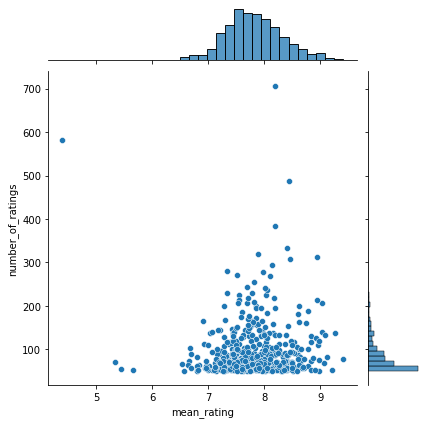

In [424]:
sns.jointplot(x='mean_rating', y='number_of_ratings', data=books_rated_GT)

In [425]:
books_selected = pd.merge(books_rated_GT['isbn'], books, on = 'isbn', how = 'inner')
books_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 506
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   isbn                 507 non-null    object
 1   book_title           507 non-null    object
 2   book_author          507 non-null    object
 3   year_of_publication  507 non-null    object
 4   publisher            507 non-null    object
dtypes: object(5)
memory usage: 23.8+ KB


In [427]:
ratings = pd.merge(only_rated, books_selected['isbn'], on = 'isbn' , how = 'inner')
users_ratings = pd.merge(ratings, users_enough_ratings['user_id'], on = 'user_id', how = 'inner')
users_ratings.head()
# users_ratings.groupby('user_id').user_id.count()

,user_id,isbn,book_rating
0,21356,038550120X,7
1,21356,0345342968,7
2,21356,0070212570,6
3,21356,068484477X,7
4,21356,031242227X,6


   There are 2183 active users that read only those books that have number of ratings > 50

# CF using lenskit functions

In [428]:
users_ratings_new = pd.DataFrame(users_ratings)
users_ratings_new.rename(columns = {'user_id':'user' , 'isbn' : 'item', 'book_rating' : 'rating'}, inplace = True)
users_ratings_new.head()

,user,item,rating
0,21356,038550120X,7
1,21356,0345342968,7
2,21356,0070212570,6
3,21356,068484477X,7
4,21356,031242227X,6


In [429]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser

# We use the collaborative user algorithm UserUser, that use the nearest neighbors 
num_recs = 10  # Number of recommendations to generate
user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(users_ratings_new)

In [430]:
books_new = pd.DataFrame(books)
books_new.rename(columns = {'isbn' : 'item'}, inplace = True)

selected_user = 254
selected_books_useruser = recsys.recommend(selected_user, 10) # generate 10 recommendations for the selected user 
# selected_books_useruser
selected_books_useruser = pd.merge(books_new, selected_books_useruser, on='item', how = 'inner')

display(selected_books_useruser)

,item,book_title,book_author,year_of_publication,publisher,score
0,0345465083,Seabiscuit,LAURA HILLENBRAND,2003,Ballantine Books,10.425888
1,0553273914,The House of the Spirits,Isabel Allende,1986,Bantam Books,10.161279
2,039592720X,Interpreter of Maladies,Jhumpa Lahiri,1999,Houghton Mifflin Co,10.099211
3,0451169530,The Stand: Complete and Uncut,Stephen King,1991,Signet Book,9.821515
4,0743225406,The Shipping News : A Novel,Annie Proulx,2001,Scribner,9.723912
5,0767902521,A Walk in the Woods: Rediscovering America on ...,Bill Bryson,1999,Broadway Books,9.801655
6,0060175400,The Poisonwood Bible,Barbara Kingsolver,1999,HarperCollins,10.092887
7,0060987561,I Know This Much Is True,Wally Lamb,1999,Regan Books,10.136119
8,0441790348,Stranger in a Strange Land (Remembering Tomorrow),Robert A. Heinlein,1995,ACE Charter,10.040328
9,0316781142,The Last Time They Met : A Novel,Anita Shreve,2001,"Little, Brown",9.745218


# Evaluation

In [431]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

train_df, test_df = train_test_split(users_ratings_new)

user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(train_df)

test_df['predicted_rating'] = recsys.predict(test_df)

test_df['relevant'] = test_df['rating'].apply(lambda x: 1 if x>3 else 0)
test_df['predicted_relevant'] = test_df['predicted_rating'].apply(lambda x: 1 if x>3 else 0)

y_test = list(test_df['relevant'])
y_pred = list(test_df['predicted_relevant'])
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print("Precision:\t" + str(precision) + 
      "\nRecall:\t" + str(recall) + 
      "\nFscore:\t" + str(fscore))

user 58497 has no ratings and none provided
user 69042 has no ratings and none provided
user 74453 has no ratings and none provided
user 134347 has no ratings and none provided
user 41831 has no ratings and none provided
user 259660 has no ratings and none provided
user 124617 has no ratings and none provided
user 211847 has no ratings and none provided
user 166017 has no ratings and none provided
user 152435 has no ratings and none provided
user 183958 has no ratings and none provided
user 85962 has no ratings and none provided
user 236955 has no ratings and none provided
user 35718 has no ratings and none provided
user 138138 has no ratings and none provided
user 37968 has no ratings and none provided
user 268751 has no ratings and none provided
user 234023 has no ratings and none provided
user 93698 has no ratings and none provided
user 243004 has no ratings and none provided
user 8284 has no ratings and none provided
user 106893 has no ratings and none provided
user 39616 has no ra

Precision:	0.9774774774774775
Recall:	0.107799304520616
Fscore:	0.1941834451901566


# Manual CF

In [261]:
matrix = users_ratings.pivot_table(index='user_id', columns='isbn', values='book_rating')
matrix

isbn,002542730X,0060096195,006016848X,0060173289,0060175400,0060199652,0060391626,0060392452,0060502258,0060915544,...,1558744630,1558745157,1559029838,1573225517,1573225789,1573227331,1573229326,1573229571,1592400876,1878424319
user_id,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm

isbn,002542730X,0060096195,006016848X,0060173289,0060175400,0060199652,0060391626,0060392452,0060502258,0060915544,...,1558744630,1558745157,1559029838,1573225517,1573225789,1573227331,1573229326,1573229571,1592400876,1878424319
user_id,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
user_similarity = matrix_norm.T.corr()
user_similarity.head()

user_id,254,638,643,709,805,882,929,1025,1131,1211,...,276670,276680,277427,277523,277639,278026,278137,278188,278221,278356
user_id,,,,,,,,,,,,,,,,,,,,,
254,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
picked_user_id = 254
user_similarity.drop(index=picked_user_id, inplace=True)
user_similarity.head()

user_id,254,638,643,709,805,882,929,1025,1131,1211,...,276670,276680,277427,277523,277639,278026,278137,278188,278221,278356
user_id,,,,,,,,,,,,,,,,,,,,,
638,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
num_neighs = 10
similarity_threshold = 0.3

similar_users = user_similarity[user_similarity[picked_user_id]>similarity_threshold][picked_user_id].sort_values(ascending=False)[:num_neighs]

print(f'The similar users for user {picked_user_id} are', similar_users)

The similar users for user 254 are user_id
7346      1.0
105517    1.0
248718    1.0
247240    1.0
219683    1.0
205735    1.0
184532    1.0
178667    1.0
177432    1.0
175636    1.0
Name: 254, dtype: float64


In [225]:
picked_user_books = matrix_norm[matrix_norm.index == picked_user_id].dropna(axis=1, how='all')
picked_user_books

isbn,0142001740,0380789035,0439064864,0439064872,0439136350,0439136369,0439139597,0451167317,0451524934,0451526341,0590353403,0671021001,0679781587
user_id,,,,,,,,,,,,,
254,0.307692,1.307692,0.307692,0.307692,0.307692,0.307692,0.307692,-0.692308,0.307692,-0.692308,0.307692,-1.692308,-0.692308


In [226]:
similar_user_books = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_books

isbn,0060096195,0060502258,0060928336,0060929871,0060930535,0060938455,0060958022,0060987103,0060987561,0064472272,...,080213825X,080410526X,0804106304,080410753X,089480829X,155874262X,1558744150,1559029838,1573225789,1878424319
user_id,,,,,,,,,,,,,,,,,,,,,
7346,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,-0.913043,NaN,-1.913043,...,NaN,NaN,1.086957,0.086957,NaN,-0.913043,NaN,0.086957,NaN,NaN
105517,NaN,NaN,NaN,NaN,NaN,NaN,-0.259259,NaN,NaN,NaN,...,NaN,2.740741,NaN,NaN,-1.259259,NaN,0.740741,NaN,NaN,-4.259259
175636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178667,NaN,-3.48,NaN,NaN,NaN,0.52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.48,NaN
184532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219683,NaN,NaN,NaN,-2.178571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.821429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247240,NaN,NaN,1.105263,NaN,-3.894737,NaN,NaN,NaN,3.105263,NaN,...,-5.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
similar_user_books.drop(picked_user_books.columns,axis=1, inplace=True, errors='ignore')
similar_user_books

isbn,0060096195,0060502258,0060928336,0060929871,0060930535,0060938455,0060958022,0060987103,0060987561,0064472272,...,080213825X,080410526X,0804106304,080410753X,089480829X,155874262X,1558744150,1559029838,1573225789,1878424319
user_id,,,,,,,,,,,,,,,,,,,,,
7346,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,-0.913043,NaN,-1.913043,...,NaN,NaN,1.086957,0.086957,NaN,-0.913043,NaN,0.086957,NaN,NaN
105517,NaN,NaN,NaN,NaN,NaN,NaN,-0.259259,NaN,NaN,NaN,...,NaN,2.740741,NaN,NaN,-1.259259,NaN,0.740741,NaN,NaN,-4.259259
175636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178667,NaN,-3.48,NaN,NaN,NaN,0.52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.48,NaN
184532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219683,NaN,NaN,NaN,-2.178571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.821429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247240,NaN,NaN,1.105263,NaN,-3.894737,NaN,NaN,NaN,3.105263,NaN,...,-5.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
item_score = {}

for i in similar_user_books.columns:
    book_rating = similar_user_books[i]
    total = 0
    count = 0
    for u in similar_users.index:
        if pd.isna(book_rating[u]) == False:
            score = similar_users[u] * book_rating[u]
            total += score
            count +=1
item_score[i] = total / count

item_score = pd.DataFrame(item_score.items(), columns=['book', 'book_score'])
ranked_item_score = item_score.sort_values(by='book_score', ascending=False)
top_books = 10
ranked_item_score.head(top_books)

,book,book_score
0,1878424319,-4.259259


# Deprecated code

In [396]:
users_noage_rating = users_noage_ratings.groupby('user_id').isbn.count().sort_values(ascending=False)
users_noage_rating = pd.DataFrame(users_noage_rating)
users_noage_rating.rename(columns = {'isbn':'number_ratings'}, inplace = True)
users_noage_rating_useless = users_noage_rating[users_noage_rating['number_ratings'] < 20] 

number_users_noage_useless = users_noage_rating_useless.count()
percentage_users_noage_useless = (number_users_noage_useless / all_users) * 100

number_ratings_users_noage_useless = users_noage_rating_useless.number_ratings.sum()
percentage_ratings_users_noage_useless = (number_ratings_users_noage_useless/total_number_ratings) * 100
print('percentage_ratings_users_noage_useless', percentage_ratings_users_noage_useless)

user_id
11676     8524
189835    1906
23902     1395
76499     1036
35859      829
          ... 
19973        1
124684       1
124669       1
124660       1
138697       1
Name: isbn, Length: 31102, dtype: int64
percentage_ratings_users_noage_useless 15.355880379365924


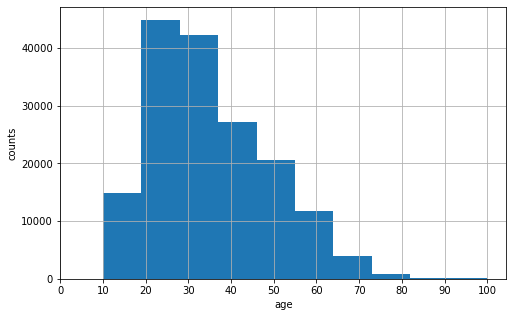

In [238]:
users.loc[(users.age<10) | (users.age>100), 'age'] = np.nan

ax = users.age.hist(figsize=(8,5))
ax.set_xlabel('age')
ax.set_ylabel('counts')
ax.set_xticks(range(0,110,10))
plt.show()

In [239]:
age_nan = users.age.isnull().sum() # Sums up the 1's returned by the isnull() mask
all_users = users.user_id.count() # Counts the number of cells in the series - excludes NaNs!
print(f'There are {age_nan} empty age values in our set of {all_users} users (or {(age_nan/all_users)*100:.2f}%).')

There are 112197 empty age values in our set of 278858 users (or 40.23%).


In [214]:
users = users.dropna()
users.head(10)

,user_id,location,age
1,2,"stockton, california, usa",18.0
3,4,"porto, v.n.gaia, portugal",17.0
5,6,"santa monica, california, usa",61.0
9,10,"albacete, wisconsin, spain",26.0
10,11,"melbourne, victoria, australia",14.0
12,13,"barcelona, barcelona, spain",26.0
17,18,"rio de janeiro, rio de janeiro, brazil",25.0
18,19,"weston, ,",14.0
19,20,"langhorne, pennsylvania, usa",19.0
20,21,"ferrol / spain, alabama, spain",46.0


In [215]:
all_users = users.user_id.count()
print(f'There are {all_users} users')

There are 166931 users


In [216]:
u = users.age.value_counts().sort_index()

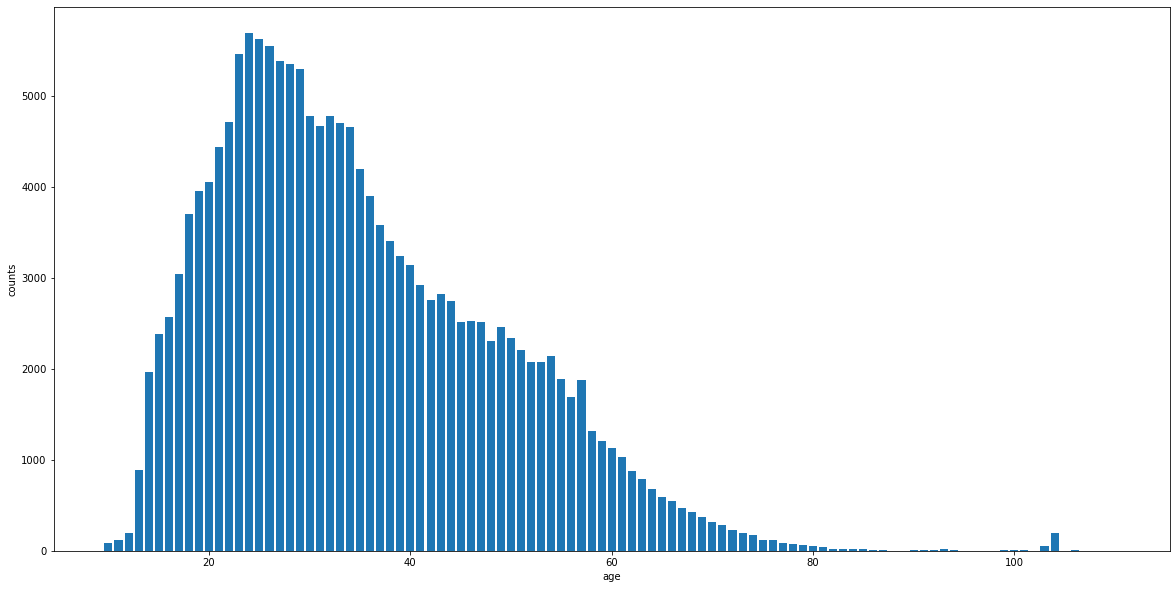

In [217]:
plt.figure(figsize=(20, 10))
plt.bar(u.index, u.values)
plt.xlabel('age')
plt.ylabel('counts')
plt.show()

In [218]:
users.loc[(users.age<15) | (users.age>110), 'age'] = np.nan
age_null = users.age.isnull().sum() # Sums up the 1's returned by the isnull() mask
all_users = users.user_id.count() # Counts the number of cells in the series - excludes NaNs!
print(f'There are {age_null} empty age values in our set of {all_users} users (or {(age_null/all_users)*100:.2f}%).')

There are 3244 empty age values in our set of 166931 users (or 1.94%).


In [219]:
book_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='cp1252')

In [220]:
book_ratings.columns = book_ratings.columns.str.strip().str.lower().str.replace('-', '_')
book_ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [221]:
book_ratings = book_ratings[book_ratings.book_rating != 0]
book_ratings.head()

,user_id,isbn,book_rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


In [222]:
super_users = book_ratings.groupby('user_id').isbn.count().sort_values(ascending=False)
super_users = pd.DataFrame(super_users)
super_users.rename(columns = {'isbn':'number_ratings'}, inplace = True)
super_users = super_users[super_users['number_ratings'] > 20] 

super_users


,number_ratings
user_id,
11676,8524
98391,5802
153662,1969
189835,1906
23902,1395
...,...
75089,21
124322,21
224923,21


In [227]:
users_ratings = pd.merge(super_users, users, how='inner', on = 'user_id')
users_ratings

,user_id,number_ratings,location,age
0,98391,5802,"morrow, georgia, usa",52.0
1,153662,1969,"ft. stewart, georgia, usa",44.0
2,171118,1035,"toronto, ontario, canada",47.0
3,235105,1023,"st louis, missouri, usa",46.0
4,16795,968,"mechanicsville, maryland, usa",47.0
...,...,...,...,...
2704,123501,21,"barcelona, catalunya, spain",27.0
2705,231891,21,"zuerich, zuerich, switzerland",33.0
2706,128915,21,"ridgeland, south carolina, usa",43.0
2707,224923,21,"cleveland, ohio, usa",24.0


In [228]:
uid = users_ratings[['user_id']].copy()
uid

,user_id
0,98391
1,153662
2,171118
3,235105
4,16795
...,...
2704,123501
2705,231891
2706,128915
2707,224923


In [229]:
book_ratings_useful =  pd.merge(book_ratings, uid, how='inner', on = 'user_id')
book_ratings_useful

,user_id,isbn,book_rating
0,276847,3257200552,5
1,276847,3404145909,8
2,276847,3404148576,8
3,276847,3404921178,7
4,276847,3423071516,10
...,...,...,...
180530,276680,1573222038,10
180531,276680,1573229083,7
180532,276680,1888173408,7
180533,276680,1888173564,8


In [231]:
df = book_ratings_useful.groupby('user_id').isbn.count().sort_values(ascending=False)
df

user_id
98391     5802
153662    1969
171118    1035
235105    1023
16795      968
          ... 
128915      21
10199       21
68256       21
224923      21
117594      21
Name: isbn, Length: 2709, dtype: int64